In [7]:
import numpy as np

## Instance Selection method for Quantum Annealing based on Local Sets

Local Set (LS) definition: <br />
def1: Given an instance c, LS(c) is the set of cases contained in the largest hypersphere centered on c such that only cases in the same class as c are contained in the hypersphere. <br />
def2: Given an instance c, LS(c) is the set of instances of the same class than c whose distance to c is shorter than the distance from c to its nearest ennemy.

Intuition behind Local Sets: <br />
The LS of an instance contains the instances that help correctly classifying it (specially in the case of K-nearest neighbors).  <br />

Definitions based on LS: <br />
*For the Instance Selection problem, (-) -> instances that should not be selected, and (+) -> instances interesting to select. <br />
- (-)* noise points: The number of LSs they belong to is lower than the number of points that have them as their nearest ennemy (LSSm). <br />
- (-) redundant points <br />
- (+) border points: These points are in the spacial limit between classes. <br />
- (+) invasive points: A kind of border points. These points can be detected with Local Set Based Clustering: They are points with Local Set Cardinality (LSC) =1 AND not belonging to else's LSs AND belonging to a unitary cluster (only with the core, which is itself). The noise can be mistakenly detected as invasive points if it is not previously removed. <br />
- (+) helpful points: These points are helpful for correctly classifying other points. They are points contained in the LS or many other points. <br />

Dataset: 5 splits of 4000 embeddings with sentiment (0-negative, 1-positive)

Ways to relate 2 instances on the basis of local sets (useful for filling the Q matrix): <br />
- nearest ennemy of every point
- local set of every point

### Approach without considering the limit in the number of decision variables --> LSSm: Local Set-based Smoother

#### Create a dataset of 2D points belonging to 2 classes

In [107]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from collections import defaultdict
import random


random_state=0

random.seed(random_state)

num_points = 40
num_classes = 2

X, y = make_blobs(n_samples=num_points, centers=num_classes, n_features=2,
                  random_state=random_state, cluster_std= 2.5)

In [108]:
print(X)
print(y)
print(type(X))
print(type(y))

[[ 1.06489705e-01  4.69465975e+00]
 [-8.57607081e-01  3.14972988e+00]
 [ 4.90376923e+00 -2.18940089e+00]
 [ 6.65065664e+00  6.67873141e-01]
 [ 4.80821811e+00  7.97718425e+00]
 [ 1.27638619e+00  1.03807702e+00]
 [-1.64511233e+00  7.53742485e-01]
 [ 7.81137067e-01 -1.97522094e-01]
 [ 7.95303503e-03  3.54803045e+00]
 [ 1.75893933e+00  2.16854798e+00]
 [ 2.08592816e+00  5.13797315e+00]
 [ 4.71146776e+00  3.79089167e+00]
 [ 3.13736058e+00  2.44837478e+00]
 [ 2.24018163e-02 -3.41804285e+00]
 [ 7.78254678e-01 -2.05391680e+00]
 [ 3.87799393e+00  1.22012094e+00]
 [ 5.64516505e+00  1.86059263e+00]
 [ 3.21942362e+00 -2.94294556e+00]
 [ 3.35149112e+00  3.92539431e+00]
 [-3.28940540e+00  9.18072582e+00]
 [-1.83398882e-01  1.86491990e+00]
 [ 3.06112162e+00 -8.14361567e-01]
 [-1.07672088e+00  2.84138955e+00]
 [ 4.05199678e+00  7.30973695e+00]
 [ 2.49883288e+00 -1.06788681e-01]
 [ 4.69462287e-01 -9.18925503e-03]
 [ 1.98481195e+00  1.96849334e+00]
 [-2.02022835e+00  2.05461930e+00]
 [-1.97947710e+00  3

In [109]:
def plot_points(X, y):

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.scatter(X[y == i, 0], X[y == i, 1], label=f'Class {i}', alpha=0.7, s=300)

    for i,x in enumerate(X):
        # Add index text inside the point
        plt.text(x[0], x[1], str(i), fontsize=10, ha='center', va='center', color='white',
                 bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.2'))

    plt.legend()
    plt.grid(True)
    plt.show()

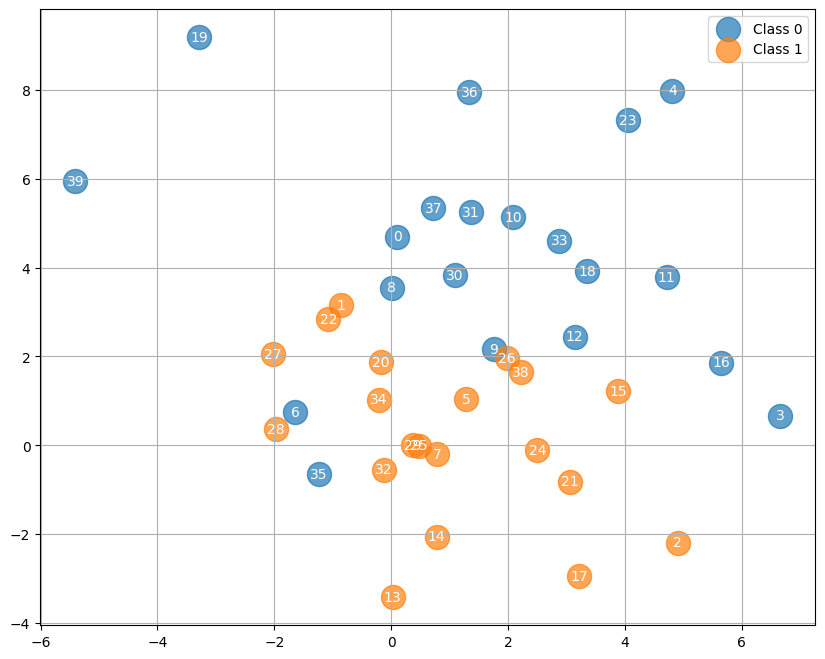

In [111]:
plot_points(X, y)

#### Computing and storing the distances between every pair of points

In [113]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# cosine_similarity(X, Y) --> returns ndarray or sparse matrix of shape (n_samples_X, n_samples_Y)
#similarities = cosine_similarity(X, X)
distances = euclidean_distances(X, X)

In [114]:
#print(similarities[:2])
print(distances[:2])

[[0.         1.82106862 8.39071998 7.6838227  5.73421461 3.83917375
  4.31264868 4.93848076 1.15085543 3.01858087 2.02847316 4.6928264
  3.77252892 8.11313837 6.78192846 5.12802731 6.22164456 8.24762829
  3.33493681 5.6264458  2.8445497  6.25133311 2.19877187 4.73346119
  5.36443966 4.71783261 3.31060082 3.39009487 4.80522341 4.70349908
  1.30621445 1.37402011 5.24908367 2.77372956 3.68102178 5.51070216
  3.47007613 0.88217641 3.70406383 5.65113075]
 [1.82106862 0.         7.85492039 7.90782125 7.44351334 3.00216673
  2.52208646 3.72687243 0.95280515 2.79446472 3.5521136  5.60586149
  4.05606528 6.62646619 5.45472111 5.11363937 6.62932276 7.33095309
  4.27997231 6.50281132 1.45096291 5.57408788 0.37826527 6.43505003
  4.67660158 3.42635129 3.07809449 1.59717106 3.00146393 3.38313806
  2.06555069 3.0564163  3.77167488 4.01094721 2.21794738 3.81745701
  5.26832002 2.69036331 3.42329517 5.33509716]]


#### Precomputing the nearest ennemy for each intance

In [7]:
# not used
def ne_sim(labels, similarities):
    '''
    Nearest ennemy based on cosine similarity: Finds the most similar instance of the opposite class for each instance.
    Returns a list where the indices are the reference/pivot instance and entries are the indices of the nearest ennemy
    ( ne[i] = j --> the nearest ennemy of i is j)
    Complexity: O^2
    '''
    ne = [-1] * len(labels) 

    for i,label_pivot in enumerate(labels):
        max_sim = -1 
        for j,label_compare in enumerate(labels):
            if(label_compare != label_pivot and similarities[i][j] > max_sim):
                max_sim = similarities[i][j]
                ne[i] = j
    return ne

In [1]:
def ne_dist(labels, distances):
    '''
    Nearest ennemy based on euclidean distance: Finds the nearest instance of the opposite class for each instance.
    Returns a list where the indices are the reference/pivot instance and entries are the indices of the nearest ennemy
    ( ne[i] = j --> the nearest ennemy of i is j)
    Complexity: O^2
    '''
    ne = [-1] * len(labels) 

    for i,label_pivot in enumerate(labels):
        min_dist = 100 
        for j,label_compare in enumerate(labels):
            if(label_compare != label_pivot and distances[i][j] < min_dist):
                min_dist = distances[i][j]
                ne[i] = j
    return ne

In [116]:
#nenemies_sim = ne_sim(y, similarities)
nenemies_dist = ne_dist(y, distances)

In [117]:
#print(nenemies_sim)
print(nenemies_dist)

[1, 8, 3, 15, 26, 9, 28, 35, 1, 26, 26, 15, 38, 35, 35, 12, 15, 3, 26, 1, 8, 9, 8, 26, 9, 35, 9, 6, 6, 35, 1, 1, 35, 26, 6, 32, 1, 1, 9, 27]


#### Visualizing Local Sets

In [118]:
import matplotlib.pyplot as plt
import random as random
import math

def print_local_sets(embeddings, labels, ne):
    '''
    Plots a scatter plot with embeddings and their local sets. The local set of an instance e is the set of instances 
    whose distance to e is smaller than the distance between e and its nearest ennemy.
    '''


    fig, ax = plt.subplots(figsize=(10, 10))

    color = []
    
    for i in range(num_classes):
        r = random.random() 
        b = random.random() 
        g = random.random() 
  
        color.append((r, g, b))
        
        plt.scatter(X[y == i, 0], X[y == i, 1], label=f'Class {i}', s=300, alpha=0.7,color=color[i])

    for i,x in enumerate(X):
        
        # Add index text inside the point
        plt.text(x[0], x[1], str(i), fontsize=10, ha='center', va='center', color='white',
                 bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.2'))
        
        # Add circles for Local Sets
        radius = math.dist(x, X[ne[i]])
        LSR_normalized= 1/(1 + np.exp(-radius)) # regulate opacity with the LSR

        if y[i] == 0:
            circle = plt.Circle(x, radius, color=color[0], fill=False, linewidth=LSR_normalized, alpha=LSR_normalized)
            ax.add_patch(circle)
        else:
            circle = plt.Circle(x, radius, color=color[1], fill=False, linewidth=LSR_normalized, alpha=LSR_normalized)
            ax.add_patch(circle)

    plt.legend()
    plt.grid(True)
     
    ax.set_aspect('equal')

    plt.show()

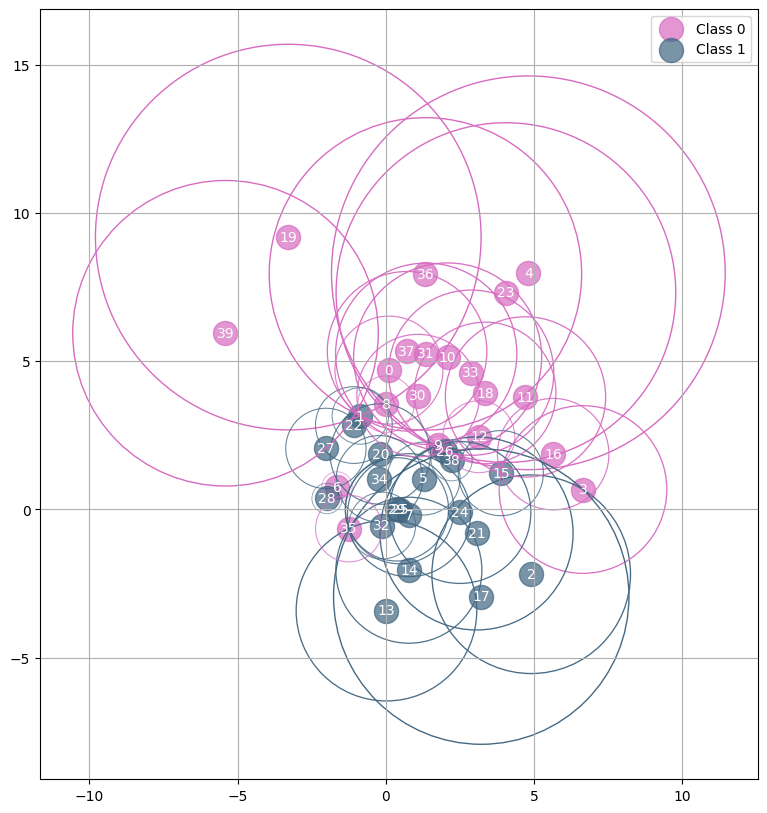

In [119]:
print_local_sets(X, y, nenemies_dist)

In [ ]:
# TODO: visualize helpfulness and harmfulness

#### Precompute local sets

In [120]:
def compute_local_sets(labels, ne, distances):
    '''
    Computes local sets as a dictionary and simultaneously sorts local sets by decreasing LSC (Local Set Cardinality).
    Returns a dictionary with the local set for every instance: key-> centroid; value-> list of cluster components
    and a list with the indices of the local sets sorted by decreasing LSC.
    
    Complexity: O^2
    '''
    LSs = defaultdict(list)
    data_size = len(ne)
    #sorted_LS_indices = [-1] * data_size
    sorted_LS_indices = defaultdict(list)
    
    for i,label_pivot in enumerate(labels):
        LSC = 0
        LSs[i]= []
        for j,label_compare in enumerate(labels):
            if label_compare == label_pivot and distances[i][j] < distances[i][ne[i]]:
                LSs[i].append(j)
                LSC = LSC +1

        #print(LSC)
        #print(data_size-LSC)
        sorted_LS_indices[data_size-LSC].append(i)
       # if(sorted_LS_indices[data_size-LSC] == -1): # if position is free
        #    sorted_LS_indices[data_size-LSC] = i

        #else: # if position is occupied
        #    sorted_LS_indices.insert(data_size-LSC, i) 
         #   sorted_LS_indices.remove(-1) # removes the first occurrence of a given item from list

    sorted_LS_indices_indexed = defaultdict(list) # indexing = assigning sequential indices

    keys = list(sorted_LS_indices.keys())
    keys.sort()
    
    for i,key in enumerate(keys): 
        sorted_LS_indices_indexed[i] = sorted_LS_indices[key]
    

    return LSs, sorted_LS_indices_indexed

In [121]:
LSs, sorted_LSC_indices = compute_local_sets(y, nenemies_dist, distances) 
print(LSs)
print(sorted_LSC_indices)

defaultdict(<class 'list'>, {0: [0, 8, 30, 31, 37], 1: [1, 22], 2: [2, 17, 21, 24], 3: [3, 16], 4: [0, 4, 8, 9, 10, 11, 12, 16, 18, 23, 30, 31, 33, 36, 37], 5: [5, 26, 38], 6: [6], 7: [5, 7, 14, 24, 25, 29, 32, 34], 8: [8], 9: [9], 10: [0, 8, 9, 10, 11, 12, 18, 23, 30, 31, 33, 36, 37], 11: [11, 12, 16, 18, 33], 12: [12], 13: [13, 14, 32], 14: [7, 13, 14, 25, 29, 32], 15: [15], 16: [3, 16], 17: [2, 5, 7, 13, 14, 15, 17, 21, 24, 25, 29, 32, 38], 18: [9, 10, 11, 12, 18, 30, 33], 19: [0, 19, 31, 36, 37, 39], 20: [1, 5, 20, 22, 34], 21: [2, 5, 7, 14, 15, 17, 21, 24, 25, 26, 29, 32, 38], 22: [1, 22, 27], 23: [0, 4, 8, 9, 10, 11, 12, 16, 18, 23, 30, 31, 33, 36, 37], 24: [5, 7, 15, 21, 24, 25, 26, 29, 38], 25: [5, 7, 25, 29, 32, 34], 26: [26], 27: [22, 27], 28: [28], 29: [5, 7, 25, 29, 32, 34], 30: [0, 8, 9, 10, 30, 31, 33, 37], 31: [0, 8, 10, 18, 30, 31, 33, 36, 37], 32: [7, 25, 29, 32], 33: [0, 9, 10, 11, 12, 18, 30, 31, 33, 37], 34: [20, 25, 29, 34], 35: [35], 36: [0, 4, 8, 10, 18, 19, 23, 

In [122]:
print(len(LSs))

40


#### Filling the QUBO matrix (unconstrained problem) -->SKIP

In [13]:
from collections import defaultdict

def unconstrained_Q1(labels, ne, distances):
    '''
    Q matrix for Instance Selection based on LS (literally LSSm) without limitation in the number of decision variables.
    penalize:
        - nearest ennemies of other instances (they can induce classification errors)
    award:
        - points belonging to local sets (they are useful for correctly classifying other points)
    limitation of this approach: 
        - it does not award border points
    '''
    
    Q = defaultdict(float)

    data_size = len(labels)
    
    for i in range(data_size):
        for j in range(i, data_size):  # Iterate through upper triangle

            if i == j:
                Q[(i, i)] = 0  #diagonal terms --> penalize LSC and LSR
                
            # off-diagonal terms --> should be simmetric


            elif ne[j] == i or ne[i] == j :
                Q[(i,j)] = 1 # penalize
                
            elif (labels[i] == labels[j] and (distances[i,j] < distances[j, ne[j]] or distances[i,j] < distances[i, ne[i]])): 
                Q[(i,j)] = -1 # reward
            else:
                Q[(i,j)] = 0 # unrelated instances
    return Q

In [17]:
max_cardinality = max(list(map(len,list(LSs.values())))) # maximum LS cardinality in the dataset
print(max_cardinality)

9


In [1]:
A=[1,2]
b = 2
print(int(b in A))

1


In [48]:
from collections import defaultdict

def unconstrained_Q2(ne, LSs):
    '''
    Q matrix for Instance Selection based on LS without limitation in the number of decision variables.
    penalize:
        - noise
        - redundant
    '''
    
    Q = defaultdict(float)

    data_size = len(ne)
    
    for i in range(data_size):
        for j in range(i, data_size):  # Iterate through upper triangle

            if i == j:
                Q[(i, i)] = 0 
                
            # off-diagonal terms --> should be simmetric


            elif ne[j] == i or ne[i] == j :
                Q[(i,j)] = 1 # penalize
                
            
            elif i in LSs[j] or j in LSs[i]:
                if len(LSs[j]) == 1 or len(LSs[i]) == 1: # border
                    Q[(i,j)] = -1

                if len(LSs[j]) >4 or len(LSs[i]) >4: # border
                    Q[(i,j)] = -1
                else:
                    Q[(i,j)] = 0.1 # menos de 1, porque queremos bordes

            else:
                Q[(i,j)] = 0 # unrelated instances
    return Q

In [ ]:
from collections import defaultdict

def unconstrained_Q2(labels, ne, LSs):
    '''
    Q matrix for Instance Selection based on LS without limitation in the number of decision variables.
    penalize:
        - noise
        - redundant
    '''
    
    Q = defaultdict(float)

    data_size = len(labels)
    max_cardinality = max(list(map(len,list(LSs.values())))) # maximum LS cardinality in the dataset
    
    for i in range(data_size):
        for j in range(i, data_size):  # Iterate through upper triangle

            if i == j:
                Q[(i, i)] = len(LSs[i])/max_cardinality  #diagonal terms --> penalize LSC (could also be LSR, but then far away points would be penalize, and we want instead dense points) 
                
            # off-diagonal terms --> should be simmetric


            elif ne[j] == i or ne[i] == j :
                Q[(i,j)] = 1 # penalize
                
            elif (labels[i] == labels[j] and (i in LSs[j] or j in LSs[j])): # and not both at the same time 
                Q[(i,j)] = -1 # reward
            else:
                Q[(i,j)] = 0 # unrelated instances
    return Q

In [14]:
Q = unconstrained_Q(y, nenemies_dist, distances)

In [15]:
print(Q)

defaultdict(<class 'float'>, {(0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): -1, (0, 4): 0, (0, 5): 0, (0, 6): 0, (0, 7): 0, (0, 8): 1, (0, 9): 0, (0, 10): 0, (0, 11): 0, (0, 12): -1, (0, 13): 1, (0, 14): 0, (0, 15): 0, (0, 16): 0, (0, 17): -1, (0, 18): 0, (0, 19): -1, (0, 20): -1, (0, 21): 0, (0, 22): 0, (0, 23): 0, (0, 24): -1, (1, 1): 0, (1, 2): -1, (1, 3): 0, (1, 4): 0, (1, 5): 0, (1, 6): 0, (1, 7): -1, (1, 8): 0, (1, 9): -1, (1, 10): 0, (1, 11): -1, (1, 12): 1, (1, 13): -1, (1, 14): 0, (1, 15): 0, (1, 16): 0, (1, 17): 0, (1, 18): 0, (1, 19): 0, (1, 20): 0, (1, 21): -1, (1, 22): -1, (1, 23): 0, (1, 24): 0, (2, 2): 0, (2, 3): 0, (2, 4): 0, (2, 5): 0, (2, 6): 0, (2, 7): -1, (2, 8): 0, (2, 9): -1, (2, 10): 0, (2, 11): -1, (2, 12): 1, (2, 13): -1, (2, 14): 0, (2, 15): 0, (2, 16): 0, (2, 17): 0, (2, 18): 0, (2, 19): 0, (2, 20): 0, (2, 21): -1, (2, 22): -1, (2, 23): 0, (2, 24): 0, (3, 3): 0, (3, 4): -1, (3, 5): 0, (3, 6): 0, (3, 7): 0, (3, 8): 0, (3, 9): 0, (3, 10): -1, (3, 11): 0, (3, 12): 0,

In [49]:
Q = unconstrained_Q2(nenemies_dist, LSs)

In [50]:
print(Q)

defaultdict(<class 'float'>, {(0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): -1, (0, 4): 0, (0, 5): 0, (0, 6): 0, (0, 7): 0, (0, 8): 1, (0, 9): 0, (0, 10): 0, (0, 11): 0, (0, 12): -1, (0, 13): 1, (0, 14): 0, (0, 15): 0, (0, 16): 0, (0, 17): -1, (0, 18): 0, (0, 19): -1, (0, 20): -1, (0, 21): 0, (0, 22): 0, (0, 23): 0, (0, 24): -1, (1, 1): 0, (1, 2): -1, (1, 3): 0, (1, 4): 0, (1, 5): 0, (1, 6): 0, (1, 7): -1, (1, 8): 0, (1, 9): -1, (1, 10): 0, (1, 11): -1, (1, 12): 1, (1, 13): 0.1, (1, 14): 0, (1, 15): 0, (1, 16): 0, (1, 17): 0, (1, 18): 0, (1, 19): 0, (1, 20): 0, (1, 21): -1, (1, 22): 0.1, (1, 23): 0, (1, 24): 0, (2, 2): 0, (2, 3): 0, (2, 4): 0, (2, 5): 0, (2, 6): 0, (2, 7): -1, (2, 8): 0, (2, 9): -1, (2, 10): 0, (2, 11): -1, (2, 12): 1, (2, 13): -1, (2, 14): 0, (2, 15): 0, (2, 16): 0, (2, 17): 0, (2, 18): 0, (2, 19): 0, (2, 20): 0, (2, 21): -1, (2, 22): -1, (2, 23): 0, (2, 24): 0, (3, 3): 0, (3, 4): -1, (3, 5): 0, (3, 6): 0, (3, 7): 0, (3, 8): 0, (3, 9): 0, (3, 10): -1, (3, 11): 0, (3, 12): 

In [21]:
print(LSs)

defaultdict(<class 'list'>, {0: [0, 3, 12, 19, 20, 24], 1: [1], 2: [1, 2, 11, 13, 22], 3: [3, 4, 10, 20, 24], 4: [4], 5: [5, 17, 20, 24], 6: [6], 7: [1, 2, 7, 8, 11, 13, 21, 22], 8: [8, 13], 9: [1, 2, 7, 9, 11, 13, 14, 21, 22], 10: [10], 11: [1, 2, 7, 9, 11, 13, 14, 21, 22], 12: [12], 13: [1, 8, 13], 14: [14], 15: [15, 23], 16: [16], 17: [0, 5, 17, 19, 20, 24], 18: [18], 19: [0, 17, 19, 20, 24], 20: [0, 3, 4, 10, 19, 20, 24], 21: [1, 2, 7, 9, 11, 13, 21, 22], 22: [1, 2, 22], 23: [15, 23], 24: [0, 3, 4, 10, 12, 17, 19, 20, 24]})


In [51]:
import numpy as np

Q_matrix = np.zeros((num_points, num_points))
for keys in Q.keys():
    Q_matrix[keys[0]][keys[1]] = Q[keys]

In [52]:
print(Q_matrix)

[[ 0.   0.   0.  -1.   0.   0.   0.   0.   1.   0.   0.   0.  -1.   1.
   0.   0.   0.  -1.   0.  -1.  -1.   0.   0.   0.  -1. ]
 [ 0.   0.  -1.   0.   0.   0.   0.  -1.   0.  -1.   0.  -1.   1.   0.1
   0.   0.   0.   0.   0.   0.   0.  -1.   0.1  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -1.   0.  -1.   0.  -1.   1.  -1.
   0.   0.   0.   0.   0.   0.   0.  -1.  -1.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0.   0.   0.   0.  -1.   0.   0.   0.
   0.   0.   0.   0.   1.   0.  -1.   0.   0.   0.  -1. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   1.   0.  -1.   0.   0.   0.  -1. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.  -1.   1.   0.  -1.   0.   0.   0.  -1. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -1.  -1.   0.  -1.   1.  -1.
   0.   0.   0.   0.   0.

### Get scores for all selections (will be replaced by Quantum Annealing)

In [22]:
import itertools
combinations = np.array(list(itertools.product([0, 1], repeat=num_points)))

In [23]:
print(combinations)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]
 ...
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]]


In [24]:
def qubo_score(x, Q):
    return x.T @ Q @ x

In [53]:
scores = [float(qubo_score(x, Q_matrix)) for x in combinations]
print(scores[:10])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
optimal_decision = scores.index(min(scores))
print(optimal_decision)

In [ ]:
print(combinations[optimal_decision])

In [40]:
#selected_embeddings = list(map(lambda a, b: a*b, combinations[optimal_decision].tolist(), X.tolist()))
#selected_labels = list(map(lambda a, b: a*b, combinations[optimal_decision].tolist(), X.tolist()))

selected_points = []
for index, value in enumerate(combinations[optimal_decision]):
    if value == 1:
        selected_points.append(index)

In [41]:
#print(selected_embeddings)
#print(selected_labels)
print(selected_points)

[0, 1, 2, 3, 4, 5, 7, 9, 10, 11, 13, 15, 17, 19, 20, 21, 22, 23, 24]


In [30]:
def plot_selected_instances(X, y, selected_points):

    print(len(selected_points))

    colors = ['blue', 'green', 'red', 'orange', 'magenta']

    # Plot the selected points
    plt.figure(figsize=(10, 8))
    for i in range(2): # 2->num_classes
        # Original points with lower alpha
        plt.scatter(X[y == i, 0], X[y == i, 1], label=f'Class {i}', alpha=0.3, color=colors[i], s=300)

        # Selected points with higher alpha and the same color
        plt.scatter(X[(y == i) & (np.isin(np.arange(num_points), selected_points)), 0],
                    X[(y == i) & (np.isin(np.arange(num_points), selected_points)), 1],
                    alpha=1, color=colors[i],marker='*', s=300)  # Use the same color

    for i,x in enumerate(X):
        
        # Add index text inside the point
        plt.text(x[0], x[1], str(i), fontsize=10, ha='center', va='center', color='white',
                 bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.2'))
        
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Selected Points using Simulated Annealing')
    plt.legend()
    plt.grid(True)
    plt.show()

21


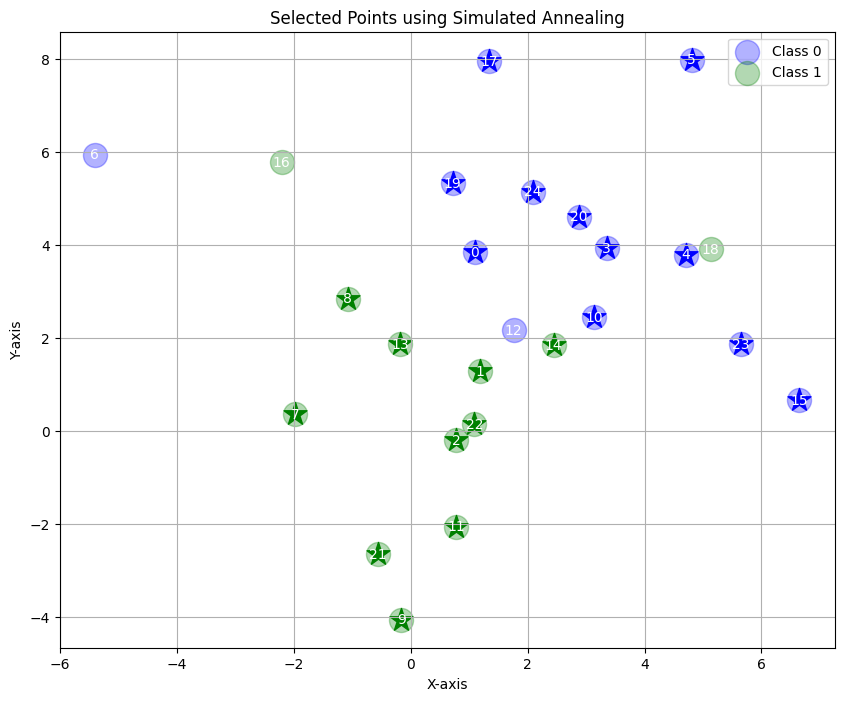

In [27]:
plot_selected_instances(X, y, selected_points)

## Approach considering the decision variables size limitation

Aproach:
- The approach performs Local Set Based Clustering and consider the cluster centroids as decision variables for selecting the instances. <br />

Local Set Based Clustering:
- LS Clustering associates each instance to the most dense local set they belong to. Density is defined with Local Set Cardinality. 
- Instances belonging to unitary clusters are either noise or border points. --> how to differentiate noise from border points?
- Clusters contain only instances of the same class.

Ways to characterize single clusters:
- Cluster size (LS Cardinality - instances belonging to larger clusters)
- Cluster radius (LS Radius having removed instances belonging to larger clusters)
    - low radius and high cardinality = trustable (not noise) cluster near the opposite class (on the border)
    - high radius = cluster with points very far from the opposite class
    - high radius and low cardinality = points far away from any other points (same and opposite class) --> are they interesting to be selected?


Ways to relate 2 clusters (c1 and c2):
- If 2 clusters are of the same class: the distance between the centroids of c1 and c2 
- If 2 clusters are of different class: whether the centroid or any other point of c1 is the nearest ennemy of the centroid or any other point of c2 --> Local set radius is the distance to the nearest ennemy.

How the size (cardinality) of the cluster is useful for selection:
- Clusters of large cardinality contain the intances in the most dense same-class spaces, so they could contain redundant instances. An idea could be to remove a random subset of these clusters.
- Clusters of small cardinality contain instances of the same class in zones with low density, so they could be important instances.
- Centroids of clusters with 1 instance are either noise or border points.
- Centroids of clusters with 0 instances are individual instances belonging to other clusters.

How to differentiate noise from border points:
- It looks like border points are either centroids of clusters with 1 instance or belong to larger clusters.
- When border points are either centroids of clusters with 1 instance, they tend to have a larger LS Radius than noise points.

### Local Set Based Clustering

Invasive points should not be classified as noise. To prevent it, noise filtering should be done beforehand.

#### Visualizing Local Set Cardinality

In [31]:
import random as random

def visualize_LSC(X, y, sorted_LSC_indices):
    
    plt.figure(figsize=(10, 8))

    unique_labels = set()
  
    color_0 = (100/255, 0, 0) # intense red, for representing high density of class 0
    color_1 = (0, 100/255, 0) # intense green, for representing high density of class 1
    
    for i in sorted_LSC_indices:

        for point in sorted_LSC_indices[i]:
            label = f"{i}" if i not in unique_labels else None  # Avoid duplicate labels
            plt.scatter(X[point, 0], X[point, 1], label=label, alpha=0.7, color=color_0 if y[point] == 0 else color_1, s=300)
            unique_labels.add(i)

        color_0 = (min(max(color_0[0] + 20/255, 0), 1), 0, 0)
        color_1 = (0, min(max(color_1[1] + 20/255, 0),1), 0)

        #r = random.random() 
        #b = random.random() 
        #g = random.random() 
  
        #color = (r, g, b)


    for i,x in enumerate(X):
        
        # Add index text inside the point
        plt.text(x[0], x[1], str(i), fontsize=10, ha='center', va='center', color='white',
                 bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.2'))
        
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Visualization of LSC')
    
    plt.legend()
    plt.grid(True)
    plt.show()

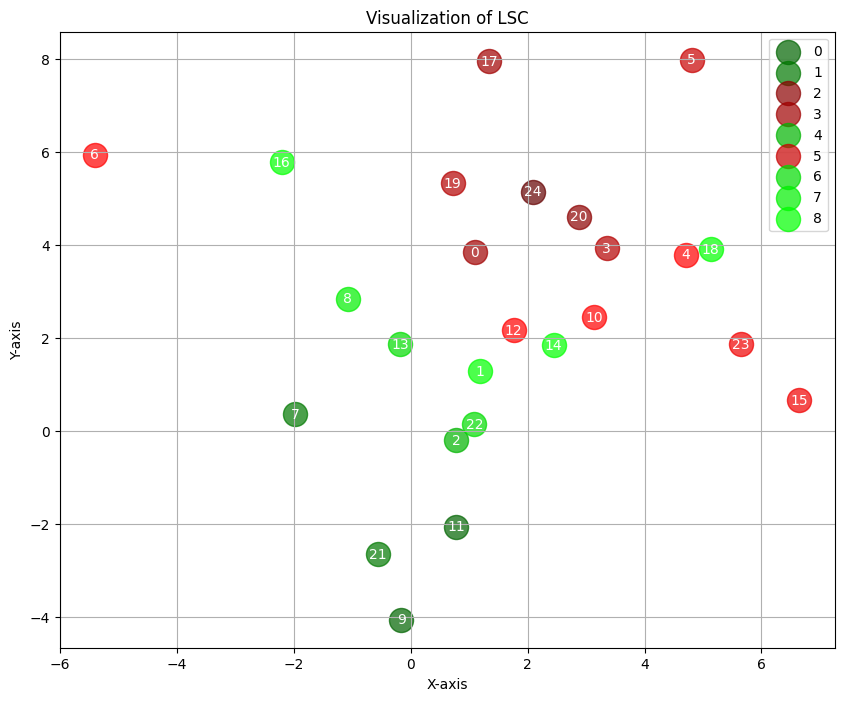

In [32]:
visualize_LSC(X, y, sorted_LSC_indices)

In [16]:
def LS_based_clustering(sorted_LSC_indices, LSs): 
    '''
    Local Set Based Clustering
    return:
    - clusters: a dictionary where key->medoids; value-> list with cluster components
    '''
    clusters = defaultdict(list)

    included_instances = []
    data_size= len(LSs)
    
    # each cluster -> key: medoid index; value: [list of instances belonging to the cluster]  
    for i in range(data_size):
        if i in sorted_LSC_indices:
            for medoid_index in sorted_LSC_indices[i]:
                if medoid_index in included_instances:
                    clusters[medoid_index] = []
                else:
                    cluster_instances = list(set(LSs[medoid_index]) - set(included_instances)) # remove already included instances
                    included_instances = list(set(included_instances).union(cluster_instances))
                    clusters[medoid_index] = cluster_instances

    return clusters

### Inverse Local Set Based Clustering

In [123]:
def LS_based_clustering_INVERSE(sorted_LSC_indices, LSs): 
    '''
    Local Set Based Clustering
    return:
    - clusters: a dictionary where key->medoids; value-> list with cluster components
    '''
    clusters = defaultdict(list)

    included_instances = []
    data_size= len(LSs)
    
    # each cluster -> key: medoid index; value: [list of instances belonging to the cluster]  
    for i in range(data_size,0,-1):
        if i in sorted_LSC_indices:
            for medoid_index in sorted_LSC_indices[i]:
                if medoid_index in included_instances:
                    clusters[medoid_index] = []
                else:
                    cluster_instances = list(set(LSs[medoid_index]) - set(included_instances)) # remove already included instances
                    included_instances = list(set(included_instances).union(cluster_instances))
                    clusters[medoid_index] = cluster_instances

    return clusters

In [124]:
clusters_inverse = LS_based_clustering_INVERSE(sorted_LSC_indices, LSs)

In [125]:
print(clusters_inverse)

defaultdict(<class 'list'>, {6: [6], 8: [8], 9: [9], 12: [12], 15: [15], 26: [26], 28: [28], 35: [35], 1: [1, 22], 3: [16, 3], 16: [], 27: [27], 38: [38], 39: [19, 39], 5: [5], 13: [32, 13, 14], 22: [], 2: [24, 17, 2, 21], 32: [], 34: [25, 34, 20, 29], 0: [0, 37, 30, 31], 11: [33, 18, 11], 20: [], 14: [], 19: [], 25: [], 29: [], 18: [], 7: [7], 30: [], 37: [], 24: [], 31: [], 33: [], 36: [10, 4, 36, 23], 10: [], 17: [], 21: []})


### Plot clusters with Local Set Based Clustering

In [126]:
import random as random 
import matplotlib.patches as mpatches

def plot_clusters(clusters, X, y, ne):
    '''
    Plots a scatter plot with embeddings and their clusters.
    '''
    fig, ax = plt.subplots(figsize=(10, 10))

    for i,x in enumerate(X):
        
        # Add index text inside the point
        plt.text(x[0], x[1], str(i), fontsize=10, ha='center', va='center', color='white',
                 bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.2'))
        
        # print local set circle only for medoids
        if len(clusters[i]) != 0: 
            radius = math.dist(x, X[ne[i]])
            if y[i] == 0:
                circle = plt.Circle(x, radius, color='red', fill=False, linewidth=1)
                ax.add_patch(circle)
            else:
                circle = plt.Circle(x, radius, color='blue', fill=False, linewidth=1)
                ax.add_patch(circle)

    # Print points with a color that assignes them to clusters
    legend_handles = []
    
    for medoid in clusters:

        if len(clusters[medoid]) == 0: continue
            
        # draw point with a characteristic color
        r = random.random() 
        b = random.random() 
        g = random.random() 
  
        color = (r, g, b)

        legend_handles.append(mpatches.Patch(color=color, label=f"cluster with medoid {medoid}"))
        
        for cluster_component in clusters[medoid]:
            plt.scatter(X[cluster_component][0], X[cluster_component][1], color=color, s=300, alpha=0.7)

    plt.legend(handles=legend_handles)
    plt.grid(True)
     
    ax.set_aspect('equal')


    plt.show()

In [24]:
plot_clusters(clusters, X, y, nenemies_dist)

NameError: name 'clusters' is not defined

### Plot clusters with inverse Local Set Based Clustering

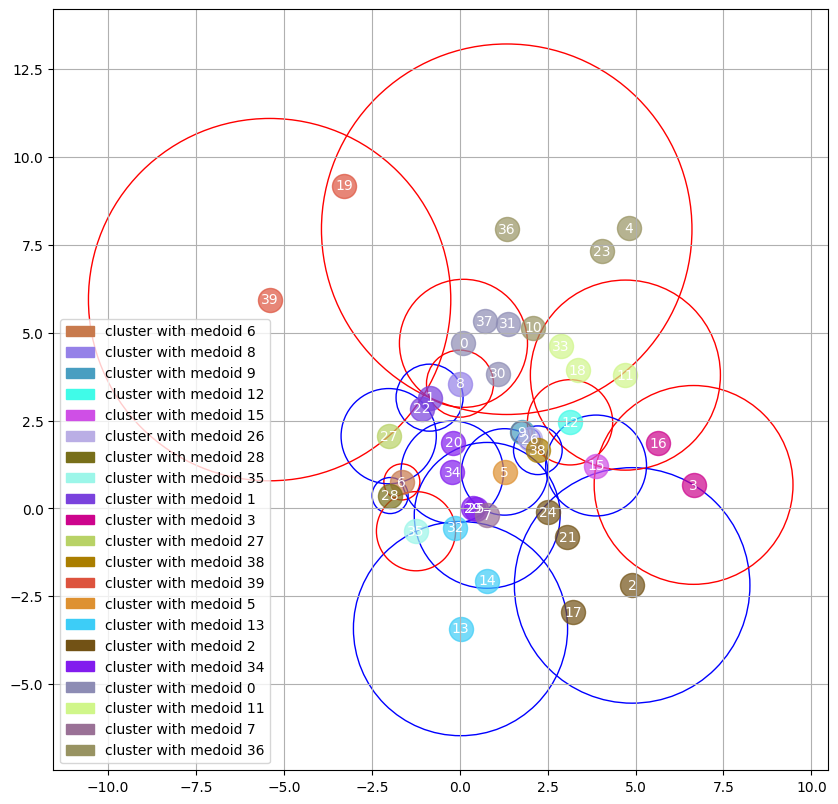

In [127]:
plot_clusters(clusters_inverse, X, y, nenemies_dist)

## Preselection of clusters: get clusters that fit in the number of decision variables

In [128]:
# dictionary entries with 0 instances are instances that are not centroids (these are not clusters, we remove them)
print(clusters_inverse.keys())
for key in clusters_inverse:
    print(clusters_inverse[key])

dict_keys([6, 8, 9, 12, 15, 26, 28, 35, 1, 3, 16, 27, 38, 39, 5, 13, 22, 2, 32, 34, 0, 11, 20, 14, 19, 25, 29, 18, 7, 30, 37, 24, 31, 33, 36, 10, 17, 21, 4, 23])
[6]
[8]
[9]
[12]
[15]
[26]
[28]
[35]
[1, 22]
[16, 3]
[]
[27]
[38]
[19, 39]
[5]
[32, 13, 14]
[]
[24, 17, 2, 21]
[]
[25, 34, 20, 29]
[0, 37, 30, 31]
[33, 18, 11]
[]
[]
[]
[]
[]
[]
[7]
[]
[]
[]
[]
[]
[10, 4, 36, 23]
[]
[]
[]
[]
[]


In [129]:
clusters_inverse_clean = defaultdict(list)
for key in clusters_inverse:
    if(len(clusters_inverse[key]) != 0):
        clusters_inverse_clean[key] = clusters_inverse[key] # add cluster

In [130]:
print(clusters_inverse_clean.keys())
for key in clusters_inverse_clean:
    print(clusters_inverse_clean[key])

dict_keys([6, 8, 9, 12, 15, 26, 28, 35, 1, 3, 27, 38, 39, 5, 13, 2, 34, 0, 11, 7, 36])
[6]
[8]
[9]
[12]
[15]
[26]
[28]
[35]
[1, 22]
[16, 3]
[27]
[38]
[19, 39]
[5]
[32, 13, 14]
[24, 17, 2, 21]
[25, 34, 20, 29]
[0, 37, 30, 31]
[33, 18, 11]
[7]
[10, 4, 36, 23]


In [140]:
num_decision_variables = 19
size = min(len(clusters_inverse_clean), num_decision_variables)
print(f'initial number of clusters: {len(clusters_inverse_clean)} \nnumber of decision variables:{num_decision_variables} \nfinal size: {size}')

initial number of clusters: 21 
number of decision variables:19 
final size: 19


In [141]:
print(list(clusters_inverse_clean.keys()))
print(list(clusters_inverse_clean.values()))

[6, 8, 9, 12, 15, 26, 28, 35, 1, 3, 27, 38, 39, 5, 13, 2, 34, 0, 11, 7, 36]
[[6], [8], [9], [12], [15], [26], [28], [35], [1, 22], [16, 3], [27], [38], [19, 39], [5], [32, 13, 14], [24, 17, 2, 21], [25, 34, 20, 29], [0, 37, 30, 31], [33, 18, 11], [7], [10, 4, 36, 23]]


### Strategy for selecting clusters when there are nore clusters than the number of decision variables: 
select for giving to the IS algorithm the clusters with smaller cardinality, all the remaining clusters are directly selected (we prioritize removing noise before redundancy)

In [142]:
# sort keys by cluster cardinality
key_cardinality = list(map(lambda key, value: [key, len(value)], list(clusters_inverse_clean.keys()), list(clusters_inverse_clean.values())))
print(key_cardinality)

[[6, 1], [8, 1], [9, 1], [12, 1], [15, 1], [26, 1], [28, 1], [35, 1], [1, 2], [3, 2], [27, 1], [38, 1], [39, 2], [5, 1], [13, 3], [2, 4], [34, 4], [0, 4], [11, 3], [7, 1], [36, 4]]


In [143]:
key_cardinality_inverse = list(map(lambda row: [row[1],row[0]], key_cardinality))

print(key_cardinality_inverse)
key_cardinality_inverse.sort()
print(key_cardinality_inverse)

[[1, 6], [1, 8], [1, 9], [1, 12], [1, 15], [1, 26], [1, 28], [1, 35], [2, 1], [2, 3], [1, 27], [1, 38], [2, 39], [1, 5], [3, 13], [4, 2], [4, 34], [4, 0], [3, 11], [1, 7], [4, 36]]
[[1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 12], [1, 15], [1, 26], [1, 27], [1, 28], [1, 35], [1, 38], [2, 1], [2, 3], [2, 39], [3, 11], [3, 13], [4, 0], [4, 2], [4, 34], [4, 36]]


In [144]:
clusters_preselected = defaultdict(list)
for i in range(size):
    key = key_cardinality_inverse[i][1]
    clusters_preselected[key] = clusters_inverse_clean[key]
print(clusters_preselected)
print(len(clusters_preselected))

defaultdict(<class 'list'>, {5: [5], 6: [6], 7: [7], 8: [8], 9: [9], 12: [12], 15: [15], 26: [26], 27: [27], 28: [28], 35: [35], 38: [38], 1: [1, 22], 3: [16, 3], 39: [19, 39], 11: [33, 18, 11], 13: [32, 13, 14], 0: [0, 37, 30, 31], 2: [24, 17, 2, 21]})
19


## Approach for filling QUBO matrix:
penalize clusters with no Local Set intersection (noise) and clusters with no member being nearest ennemies (redundant) and award border pairs

In [145]:
has_ne_of = [[0 for _ in range(size)] for _ in range(size)]
has_LS_member = [[0 for _ in range(size)] for _ in range(size)]

for i in range(size):
    cluster_i_components = list(clusters_preselected.values())[i]

    for j in range(i+1, size): # for each different pair of clusters
        cluster_j_components = list(clusters_preselected.values())[j]
        for comp_i in cluster_i_components:
            for comp_j in cluster_j_components:  

                    if(nenemies_dist[comp_j] == comp_i): # cluster i has a ne of cluster j
                        has_ne_of[i][j] = has_ne_of[i][j] + 1 
                        
                    if(nenemies_dist[comp_i] == comp_j): # cluster j has a ne of cluster i
                        has_ne_of[j][i] = has_ne_of[j][i] + 1 
                        
                    if(comp_i in LSs[comp_j]): # cluster i has a member of a LS of cluster j
                        has_LS_member[i][j] = has_LS_member[i][j] + 1
                        
                    if(comp_j in LSs[comp_i]): # cluster j has a member of a LS of cluster i
                        has_LS_member[j][i] = has_LS_member[j][i] + 1 
                    
import numpy as np  

print(f'cluster nearest ennemies (cluster i has x nearest ennemies of cluster j): \n {np.array(has_ne_of)}')
print()
print(f'cluster members of LSs of other clusters: \n {np.array(has_LS_member)}') # Comment: take into account that LS with higher cardinality have higher LS intersection

cluster nearest ennemies (cluster i has x nearest ennemies of cluster j): 
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

cluster members of LSs of other clusters: 
 [[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0

In [146]:
total_cluster_nes = list(map(sum, has_ne_of))
total_cluster_LSs_members = list(map(sum, has_LS_member)) 
#cluster_noise_score = list(map(lambda a, b: a-b, total_cluster_ne, total_cluster_LS))

has_a_ne = list(map(lambda a: 0 if a == 0 else 1, total_cluster_nes))
has_a_LS_member = list(map(lambda a: 0 if a == 0 else 1, total_cluster_LSs_members))

print(f'total cluster nearest ennemies: \n {np.array(total_cluster_nes)}')
print()
print(f'total cluster members belonging to Local Sets: \n {np.array(total_cluster_LSs_members)}') 
print()
print(f'clusters having nearest ennemies: \n {np.array(has_a_ne)}')
print()
print(f'clusters having members belonging to Local Sets: \n {np.array(has_a_LS_member)}')       

total cluster nearest ennemies: 
 [0 2 0 2 5 1 3 3 1 1 4 1 6 2 0 0 1 0 0]

total cluster members belonging to Local Sets: 
 [4 0 5 4 3 3 3 4 1 0 0 4 1 1 0 4 7 8 1]

clusters having nearest ennemies: 
 [0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0]

clusters having members belonging to Local Sets: 
 [1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1]


### Preliminary noise and outlier removal (LSSm)

In [154]:
clusters_filtered = defaultdict(list)
filtered_keys = list(map(lambda key, LS_members, nearest_ennemies: key if LS_members >= nearest_ennemies else -1, clusters_preselected.keys(), total_cluster_LSs_members, total_cluster_nes))
print(filtered_keys)

[5, -1, 7, 8, -1, 12, 15, 26, 27, -1, -1, 38, -1, -1, 39, 11, 13, 0, 2]


In [155]:
for key in filtered_keys:
    if key != -1:
        clusters_filtered[key] = clusters_preselected[key]

print(clusters_filtered)

defaultdict(<class 'list'>, {5: [5], 7: [7], 8: [8], 12: [12], 15: [15], 26: [26], 27: [27], 38: [38], 39: [19, 39], 11: [33, 18, 11], 13: [32, 13, 14], 0: [0, 37, 30, 31], 2: [24, 17, 2, 21]})


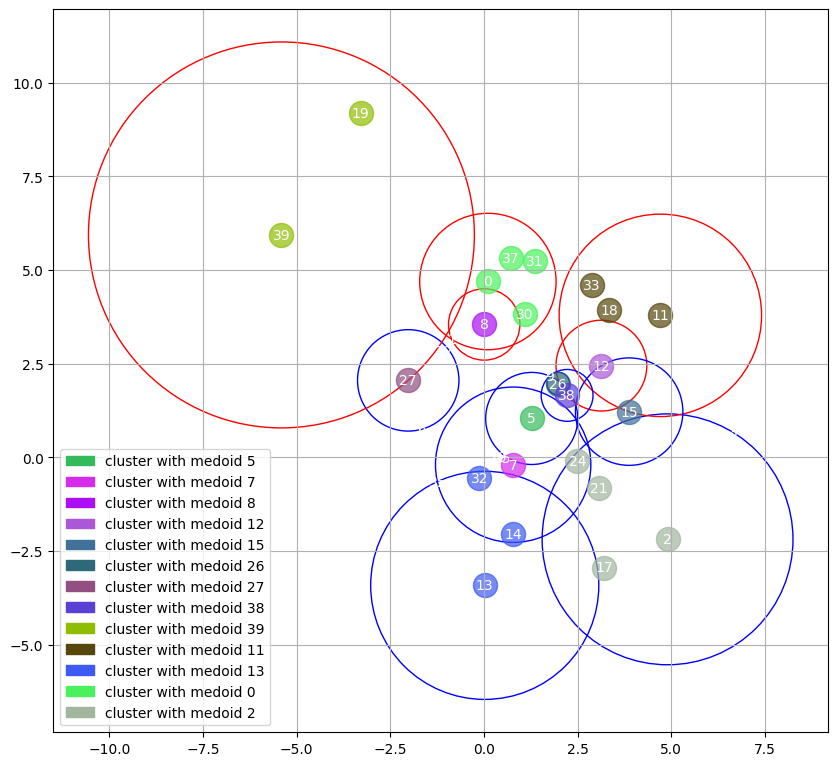

In [156]:
plot_clusters(clusters_filtered, X, y, nenemies_dist)

### Saving in a dictionary the indices of the selected instances (from now on, indices will change)

In [157]:
filtered_instances = []
for cluster_members in list(clusters_filtered.values()):
    filtered_instances = filtered_instances + cluster_members
print(filtered_instances)

[5, 7, 8, 12, 15, 26, 27, 38, 19, 39, 33, 18, 11, 32, 13, 14, 0, 37, 30, 31, 24, 17, 2, 21]


In [158]:
selected_indices_dict = defaultdict(list)
for new_i, old_i in enumerate(filtered_instances):
    selected_indices_dict[new_i] = old_i

print(selected_indices_dict)

defaultdict(<class 'list'>, {0: 5, 1: 7, 2: 8, 3: 12, 4: 15, 5: 26, 6: 27, 7: 38, 8: 19, 9: 39, 10: 33, 11: 18, 12: 11, 13: 32, 14: 13, 15: 14, 16: 0, 17: 37, 18: 30, 19: 31, 20: 24, 21: 17, 22: 2, 23: 21})


### With only the selected indices, we perform again inverse LS clustering

In [216]:
X_filtered = X[filtered_instances]
y_filtered = y[filtered_instances]
print(len(X_filtered))
print(len(y_filtered))
print(X_filtered)
print(y_filtered)

24
24
[[ 1.27638619e+00  1.03807702e+00]
 [ 7.81137067e-01 -1.97522094e-01]
 [ 7.95303503e-03  3.54803045e+00]
 [ 3.13736058e+00  2.44837478e+00]
 [ 3.87799393e+00  1.22012094e+00]
 [ 1.98481195e+00  1.96849334e+00]
 [-2.02022835e+00  2.05461930e+00]
 [ 2.22156058e+00  1.65384340e+00]
 [-3.28940540e+00  9.18072582e+00]
 [-5.40620446e+00  5.93783382e+00]
 [ 2.87886439e+00  4.60797487e+00]
 [ 3.35149112e+00  3.92539431e+00]
 [ 4.71146776e+00  3.79089167e+00]
 [-1.21725352e-01 -5.49460502e-01]
 [ 2.24018163e-02 -3.41804285e+00]
 [ 7.78254678e-01 -2.05391680e+00]
 [ 1.06489705e-01  4.69465975e+00]
 [ 7.18222949e-01  5.33028358e+00]
 [ 1.09066637e+00  3.83582770e+00]
 [ 1.36363864e+00  5.24919363e+00]
 [ 2.49883288e+00 -1.06788681e-01]
 [ 3.21942362e+00 -2.94294556e+00]
 [ 4.90376923e+00 -2.18940089e+00]
 [ 3.06112162e+00 -8.14361567e-01]]
[1 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1]


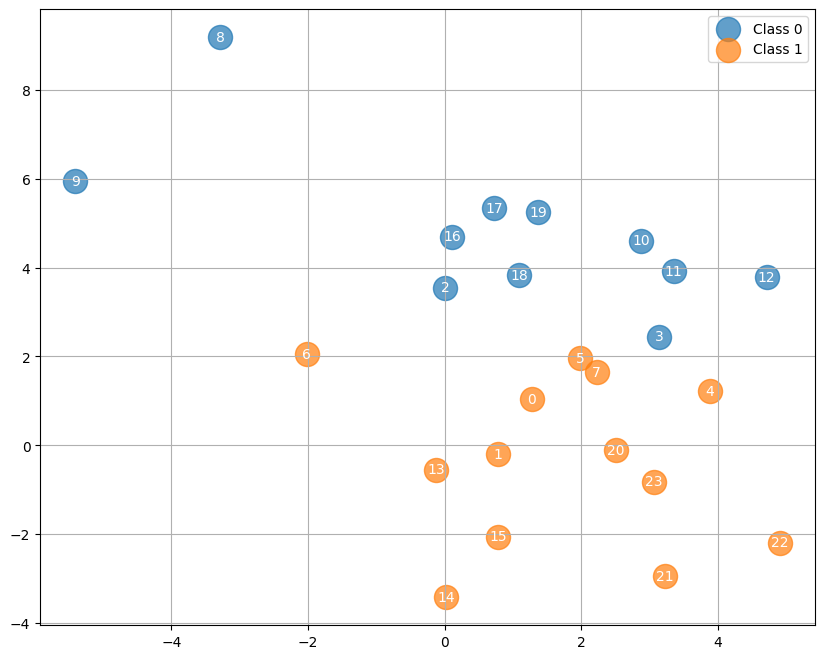

In [217]:
plot_points(X_filtered, y_filtered)

In [218]:
distances_filtered = euclidean_distances(X_filtered, X_filtered)
print(distances_filtered.shape)
nenemies_dist_filtered = ne_dist(y_filtered, distances_filtered)
print(nenemies_dist_filtered)
print(len(nenemies_dist_filtered))

(24, 24)
[3, 3, 6, 7, 3, 3, 2, 3, 6, 6, 5, 5, 4, 2, 3, 3, 5, 5, 5, 5, 3, 3, 3, 3]
24


In [219]:
import matplotlib.pyplot as plt
import random as random
import math

def print_local_sets(X, y, ne):
    '''
    Plots a scatter plot with embeddings and their local sets. The local set of an instance e is the set of instances 
    whose distance to e is smaller than the distance between e and its nearest ennemy.
    '''


    fig, ax = plt.subplots(figsize=(10, 10))

    color = []
    
    for i in range(num_classes):
        r = random.random() 
        b = random.random() 
        g = random.random() 
  
        color.append((r, g, b))
        
        plt.scatter(X[y == i, 0], X[y == i, 1], label=f'Class {i}', s=300, alpha=0.7,color=color[i])

    for i,x in enumerate(X):
        
        # Add index text inside the point
        plt.text(x[0], x[1], str(i), fontsize=10, ha='center', va='center', color='white',
                 bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.2'))
        
        # Add circles for Local Sets
        radius = math.dist(x, X[ne[i]])
        LSR_normalized= 1/(1 + np.exp(-radius)) # regulate opacity with the LSR

        if y[i] == 0:
            circle = plt.Circle(x, radius, color=color[0], fill=False, linewidth=LSR_normalized, alpha=LSR_normalized)
            ax.add_patch(circle)
        else:
            circle = plt.Circle(x, radius, color=color[1], fill=False, linewidth=LSR_normalized, alpha=LSR_normalized)
            ax.add_patch(circle)

    plt.legend()
    plt.grid(True)
     
    ax.set_aspect('equal')

    plt.show()

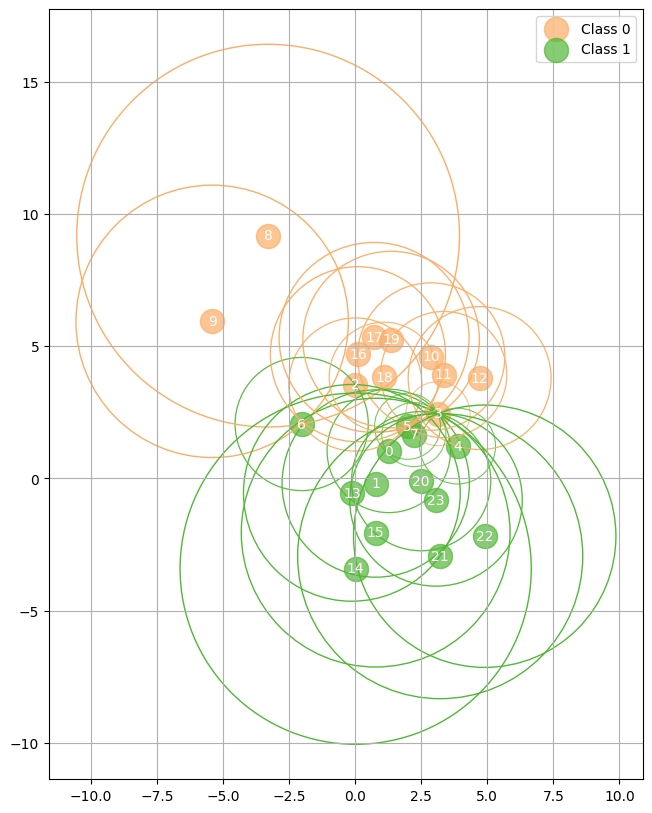

In [220]:
print_local_sets(X_filtered, y_filtered, nenemies_dist_filtered)

In [221]:
LSs_filtered, sorted_LSC_indices_filtered = compute_local_sets(y_filtered, nenemies_dist_filtered, distances_filtered) 
print(LSs_filtered)
print(sorted_LSC_indices_filtered)

defaultdict(<class 'list'>, {0: [0, 1, 5, 7, 13, 20], 1: [0, 1, 4, 5, 7, 13, 14, 15, 20, 23], 2: [2, 16, 17, 18, 19], 3: [3], 4: [4], 5: [0, 5, 7], 6: [6], 7: [0, 5, 7], 8: [2, 8, 9, 16, 17, 18, 19], 9: [8, 9], 10: [3, 10, 11, 12, 16, 17, 18, 19], 11: [3, 10, 11, 12, 18], 12: [3, 10, 11, 12], 13: [0, 1, 5, 6, 7, 13, 14, 15, 20, 23], 14: [0, 1, 4, 5, 6, 7, 13, 14, 15, 20, 21, 22, 23], 15: [0, 1, 4, 5, 6, 7, 13, 14, 15, 20, 21, 22, 23], 16: [2, 10, 16, 17, 18, 19], 17: [2, 10, 11, 16, 17, 18, 19], 18: [2, 10, 16, 17, 18, 19], 19: [2, 3, 10, 11, 16, 17, 18, 19], 20: [0, 1, 4, 5, 7, 15, 20, 23], 21: [0, 1, 4, 5, 7, 13, 14, 15, 20, 21, 22, 23], 22: [0, 1, 4, 7, 15, 20, 21, 22, 23], 23: [0, 1, 4, 5, 7, 13, 15, 20, 21, 22, 23]})
defaultdict(<class 'list'>, {0: [14, 15], 1: [21], 2: [23], 3: [1, 13], 4: [22], 5: [10, 19, 20], 6: [8, 17], 7: [0, 16, 18], 8: [2, 11], 9: [12], 10: [5, 7], 11: [9], 12: [3, 4, 6]})


In [222]:
print(len(LSs_filtered))

24


In [223]:
clusters_inverse_filtered = LS_based_clustering_INVERSE(sorted_LSC_indices_filtered, LSs_filtered)

In [224]:
print(clusters_inverse_filtered)

defaultdict(<class 'list'>, {3: [3], 4: [4], 6: [6], 9: [8, 9], 5: [0, 5, 7], 7: [], 12: [10, 11, 12], 2: [2, 16, 17, 18, 19], 11: [], 0: [], 16: [], 18: [], 8: [], 17: [], 10: [], 19: [], 20: [1, 20, 23, 15], 22: [21, 22], 1: [], 13: [13, 14], 23: [], 21: []})


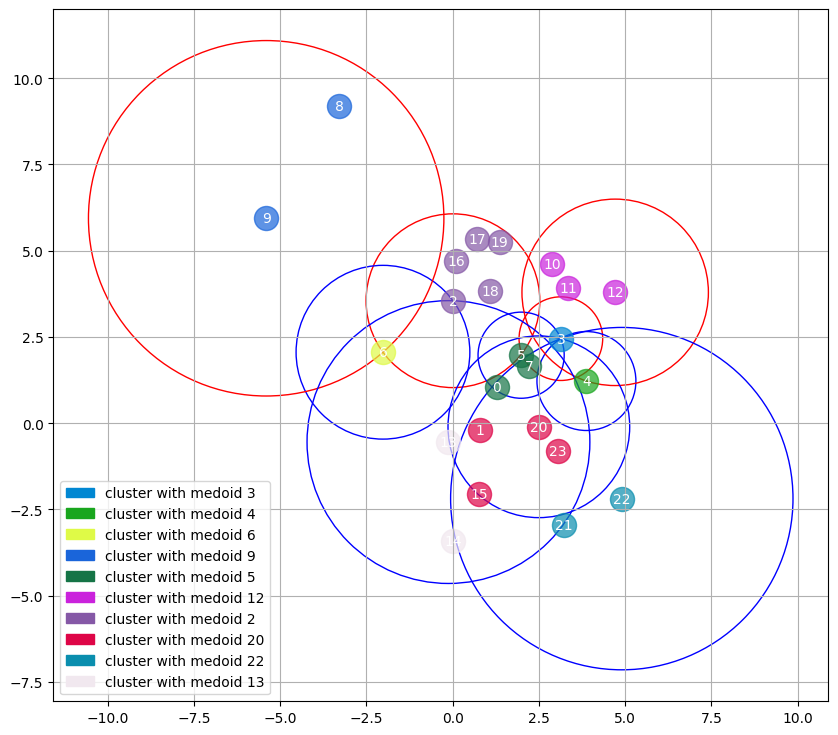

In [225]:
plot_clusters(clusters_inverse_filtered, X_filtered, y_filtered, nenemies_dist_filtered)

In [226]:
# dictionary entries with 0 instances are instances that are not centroids (these are not clusters, we remove them)
for key in clusters_inverse_filtered:
    print(clusters_inverse_filtered[key])

[3]
[4]
[6]
[8, 9]
[0, 5, 7]
[]
[10, 11, 12]
[2, 16, 17, 18, 19]
[]
[]
[]
[]
[]
[]
[]
[]
[1, 20, 23, 15]
[21, 22]
[]
[13, 14]
[]
[]
[]
[]


In [227]:
clusters_inverse_filtered_clean = defaultdict(list)
for key in clusters_inverse_filtered:
    if(len(clusters_inverse_filtered[key]) != 0):
        clusters_inverse_filtered_clean[key] = clusters_inverse_filtered[key] # add cluster

In [228]:
print(clusters_inverse_filtered_clean.keys())
for key in clusters_inverse_filtered_clean:
    print(clusters_inverse_filtered_clean[key])

dict_keys([3, 4, 6, 9, 5, 12, 2, 20, 22, 13])
[3]
[4]
[6]
[8, 9]
[0, 5, 7]
[10, 11, 12]
[2, 16, 17, 18, 19]
[1, 20, 23, 15]
[21, 22]
[13, 14]


In [229]:
num_decision_variables = 19
size = min(len(clusters_inverse_filtered_clean), num_decision_variables)
print(f'initial number of clusters: {len(clusters_inverse_filtered_clean)} \nnumber of decision variables:{num_decision_variables} \nfinal size: {size}')

initial number of clusters: 10 
number of decision variables:19 
final size: 10


### Strategy for selecting clusters when there are more clusters than the number of decision variables: 
select for giving to the IS algorithm the clusters with smaller cardinality, all the remaining clusters are directly selected (we prioritize removing noise before redundancy)

In [230]:
# sort keys by cluster cardinality
key_cardinality = list(map(lambda key, value: [key, len(value)], list(clusters_inverse_filtered_clean.keys()), list(clusters_inverse_filtered_clean.values())))
print(key_cardinality)
print(len(key_cardinality))

[[3, 1], [4, 1], [6, 1], [9, 2], [5, 3], [12, 3], [2, 5], [20, 4], [22, 2], [13, 2]]
10


In [231]:
key_cardinality_inverse = list(map(lambda row: [row[1],row[0]], key_cardinality))

print(key_cardinality_inverse)
print(len(key_cardinality_inverse))
key_cardinality_inverse.sort()
print(key_cardinality_inverse)

[[1, 3], [1, 4], [1, 6], [2, 9], [3, 5], [3, 12], [5, 2], [4, 20], [2, 22], [2, 13]]
10
[[1, 3], [1, 4], [1, 6], [2, 9], [2, 13], [2, 22], [3, 5], [3, 12], [4, 20], [5, 2]]


In [257]:
clusters_filtered_preselected = defaultdict(list)
for i in range(size):
    key = key_cardinality_inverse[i][1]
    clusters_filtered_preselected[key] = clusters_inverse_filtered_clean[key]
print(clusters_filtered_preselected)
print(len(clusters_filtered_preselected))

defaultdict(<class 'list'>, {3: [3], 4: [4], 6: [6], 9: [8, 9], 13: [13, 14], 22: [21, 22], 5: [0, 5, 7], 12: [10, 11, 12], 20: [1, 20, 23, 15], 2: [2, 16, 17, 18, 19]})
10


In [258]:
selected_y = list(int(y_filtered[i]) for i in list(clusters_filtered_preselected.keys()))
selected_y = np.array(selected_y)

In [259]:
print(clusters_filtered_preselected.keys())
print(y_filtered)
print(selected_y)
print(len(selected_y))
print(type(y_filtered))
print(type(selected_y))

dict_keys([3, 4, 6, 9, 13, 22, 5, 12, 20, 2])
[1 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1]
[0 1 1 0 1 1 1 0 1 0]
10
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Approach for filling QUBO matrix:
penalize clusters with no Local Set intersection (noise) and clusters with no member being nearest ennemies (redundant) and award border pairs

In [262]:
has_ne_of = [[0 for _ in range(size)] for _ in range(size)]
has_LS_member = [[0 for _ in range(size)] for _ in range(size)]

for i in range(size):
    cluster_i_components = list(clusters_filtered_preselected.values())[i]

    for j in range(i+1, size): # for each different pair of clusters
        cluster_j_components = list(clusters_filtered_preselected.values())[j]
        for comp_i in cluster_i_components:
            for comp_j in cluster_j_components:  

                    if(nenemies_dist_filtered[comp_j] == comp_i): # cluster i has a ne of cluster j
                        has_ne_of[i][j] = has_ne_of[i][j] + 1 
                        
                    if(nenemies_dist_filtered[comp_i] == comp_j): # cluster j has a ne of cluster i
                        has_ne_of[j][i] = has_ne_of[j][i] + 1 
                        
                    if(comp_i in LSs_filtered[comp_j]): # cluster i has a member of a LS of cluster j
                        has_LS_member[i][j] = has_LS_member[i][j] + 1
                        
                    if(comp_j in LSs_filtered[comp_i]): # cluster j has a member of a LS of cluster i
                        has_LS_member[j][i] = has_LS_member[j][i] + 1 
                    
import numpy as np  

print(f'cluster nearest ennemies (cluster i has x nearest ennemies of cluster j): \n {np.array(has_ne_of)}')
print()
print(f'cluster members of LSs of other clusters: \n {np.array(has_LS_member)}') # Comment: take into account that LS with higher cardinality have higher LS intersection

cluster nearest ennemies (cluster i has x nearest ennemies of cluster j): 
 [[0 1 0 0 1 2 3 0 4 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 2 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 2 0 4]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0]]

cluster members of LSs of other clusters: 
 [[ 0  0  0  0  0  0  0  3  0  1]
 [ 0  0  0  0  1  2  0  0  4  0]
 [ 0  0  0  0  2  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  1  0  5  0]
 [ 0  0  0  0  2  0  0  0  4  0]
 [ 0  0  0  0  6  5  0  0 12  0]
 [ 0  0  0  0  0  0  0  0  0  6]
 [ 0  0  0  0  8  8  2  0  0  0]
 [ 0  0  0  5  0  0  0  5  0  0]]


In [263]:
total_cluster_nes = list(map(sum, has_ne_of))
total_cluster_LSs_members = list(map(sum, has_LS_member)) 
#cluster_noise_score = list(map(lambda a, b: a-b, total_cluster_ne, total_cluster_LS))

has_a_ne = list(map(lambda a: 0 if a == 0 else 1, total_cluster_nes))
has_a_LS_member = list(map(lambda a: 0 if a == 0 else 1, total_cluster_LSs_members))

print(f'total cluster nearest ennemies: \n {np.array(total_cluster_nes)}')
print()
print(f'total cluster members belonging to Local Sets: \n {np.array(total_cluster_LSs_members)}') 
print()
print(f'clusters having nearest ennemies: \n {np.array(has_a_ne)}')
print()
print(f'clusters having members belonging to Local Sets: \n {np.array(has_a_LS_member)}')       

total cluster nearest ennemies: 
 [11  1  3  0  0  0  7  0  0  2]

total cluster members belonging to Local Sets: 
 [ 4  7  3  0  8  6 23  6 18 10]

clusters having nearest ennemies: 
 [1 1 1 0 0 0 1 0 0 1]

clusters having members belonging to Local Sets: 
 [1 1 1 0 1 1 1 1 1 1]


## Quantum Annealing will be used for redundancy removal
- award: same class clusters with members of local sets (borders belong to more local sets)
- award: opposite class clusters with nearest ennemies

In [264]:
Q = defaultdict(float) 

for i in range(size):   
    for j in range(i, size): 
            
        if(i == j):
                Q[(i,j)] = - 0.1*total_cluster_nes[i] 
            #10*len(clusters_filtered_preselected[i])
        else:
            if(selected_y[i] == selected_y[j]): # same class --> tener en cuenta que lo mismo no se cogen todas (modificar y_filtered)
                #Q[(i,j)] = - has_LS_member[j][i]*(1 + 0.1*total_cluster_nes[i]) - has_LS_member[i][j]* (1 + 0.1*total_cluster_nes[j])
                Q[(i,j)] = - has_LS_member[j][i] - has_LS_member[i][j]

            else: # opposite class
                Q[(i,j)] = - has_ne_of[i][j] - has_ne_of[j][i]

In [265]:
print(Q)

defaultdict(<class 'float'>, {(0, 0): -1.1, (0, 1): -1, (0, 2): 0, (0, 3): 0, (0, 4): -1, (0, 5): -2, (0, 6): -4, (0, 7): -3, (0, 8): -4, (0, 9): -1, (1, 1): -0.1, (1, 2): 0, (1, 3): 0, (1, 4): -1, (1, 5): -2, (1, 6): 0, (1, 7): -1, (1, 8): -4, (1, 9): 0, (2, 2): -0.30000000000000004, (2, 3): -2, (2, 4): -2, (2, 5): 0, (2, 6): 0, (2, 7): 0, (2, 8): -1, (2, 9): -2, (3, 3): -0.0, (3, 4): 0, (3, 5): 0, (3, 6): 0, (3, 7): 0, (3, 8): 0, (3, 9): -5, (4, 4): -0.0, (4, 5): -4, (4, 6): -7, (4, 7): 0, (4, 8): -13, (4, 9): -1, (5, 5): -0.0, (5, 6): -5, (5, 7): 0, (5, 8): -12, (5, 9): 0, (6, 6): -0.7000000000000001, (6, 7): -2, (6, 8): -14, (6, 9): -4, (7, 7): -0.0, (7, 8): 0, (7, 9): -11, (8, 8): -0.0, (8, 9): 0, (9, 9): -0.2})


In [266]:
print(f'awarded pairs: \n{list(map(lambda key, val: key if val < 0 else None, list(Q.keys()), list(Q.values())))}')

awarded pairs: 
[(0, 0), (0, 1), None, None, (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 1), None, None, (1, 4), (1, 5), None, (1, 7), (1, 8), None, (2, 2), (2, 3), (2, 4), None, None, None, (2, 8), (2, 9), None, None, None, None, None, None, (3, 9), None, (4, 5), (4, 6), None, (4, 8), (4, 9), None, (5, 6), None, (5, 8), None, (6, 6), (6, 7), (6, 8), (6, 9), None, None, (7, 9), None, None, (9, 9)]


In [240]:
import numpy as np

Q_matrix = np.zeros((size, size))
for keys in Q.keys():
    Q_matrix[keys[0]][keys[1]] = Q[keys]

### Get scores for all selections (will be replaced by Quantum Annealing)

In [241]:
import itertools
combinations = np.array(list(itertools.product([0, 1], repeat=size)))

In [242]:
print(combinations)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]
 ...
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]]


In [243]:
def qubo_score(x, Q, y, lam_total=1.0, lam_balance=2.0):
    n = x.shape[0]
    
    # Penalty for selecting exactly  a % of instances
    target_total = 0.8 * n
    penalty_total = lam_total * (x.sum() - target_total) ** 2

    # Penalty for selecting 50/50 class balance
    class_0_mask = (selected_y == 0)
    class_1_mask = (selected_y == 1)
    
    selected_class_0 = x[class_0_mask].sum()
    selected_class_1 = x[class_1_mask].sum()
    
    penalty_balance = lam_balance * (selected_class_0 - selected_class_1) ** 2

    return x.T @ Q @ x + penalty_total + penalty_balance

In [244]:
class_0_mask = (selected_y == 0)
class_1_mask = (selected_y == 1)
print(class_0_mask)
print(len(class_0_mask))

[ True False False  True False False False  True False  True]
10


In [245]:
scores = [float(qubo_score(x, Q_matrix, y_filtered)) for x in combinations]
print(scores[:10])

[64.0, 50.8, 51.0, 35.8, 51.0, 32.8, 36.0, 15.8, 50.3, 31.1]


In [246]:
optimal_decision = scores.index(min(scores))
print(optimal_decision)

895


In [247]:
print(combinations[optimal_decision])

[1 1 0 1 1 1 1 1 1 1]


In [253]:
#selected_embeddings = list(map(lambda a, b: a*b, combinations[optimal_decision].tolist(), X.tolist()))
#selected_labels = list(map(lambda a, b: a*b, combinations[optimal_decision].tolist(), X.tolist()))

selected_clusters = []
for index, value in enumerate(combinations[optimal_decision]):
    if value == 1:
        selected_clusters.append(index)

In [254]:
#print(selected_embeddings)
#print(selected_labels)
print(selected_clusters)

[0, 1, 3, 4, 5, 6, 7, 8, 9]


In [260]:
print(clusters_filtered_preselected)

defaultdict(<class 'list'>, {3: [3], 4: [4], 6: [6], 9: [8, 9], 13: [13, 14], 22: [21, 22], 5: [0, 5, 7], 12: [10, 11, 12], 20: [1, 20, 23, 15], 2: [2, 16, 17, 18, 19]})


In [261]:
selected_points = []
for key in selected_clusters:
    selected_points = selected_points + clusters_filtered_preselected[key]

print(selected_points)

[3, 4, 0, 5, 7, 6, 8, 9]


In [204]:
import matplotlib.pyplot as plt
import numpy as np

def plot_selected_instances(X_filtered, y_filtered, selected_points):
    print("Number of selected points:", len(selected_points))

    colors = ['blue', 'green', 'red', 'orange', 'magenta']
    num_classes = len(np.unique(y_filtered))
    size = len(X_filtered)

    selected_mask = np.zeros(size, dtype=bool)
    selected_mask[selected_points] = True

    plt.figure(figsize=(10, 8))

    for i in range(num_classes):
        class_mask = (y_filtered == i)

        # Plot all class points (faded)
        plt.scatter(X_filtered[class_mask, 0], X_filtered[class_mask, 1],
                    label=f'Class {i}', alpha=0.3, color=colors[i % len(colors)], s=300)

        # Plot selected points in this class
        class_selected_mask = class_mask & selected_mask
        plt.scatter(X_filtered[class_selected_mask, 0], X_filtered[class_selected_mask, 1],
                    alpha=1, color=colors[i % len(colors)], marker='*', s=300)

    # Add indices as text on each point
    for i, x in enumerate(X_filtered):
        plt.text(x[0], x[1], str(i), fontsize=10, ha='center', va='center', color='white',
                 bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.2'))

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Selected Points using Simulated Annealing')
    plt.legend()
    plt.grid(True)
    plt.show()


Number of selected points: 9


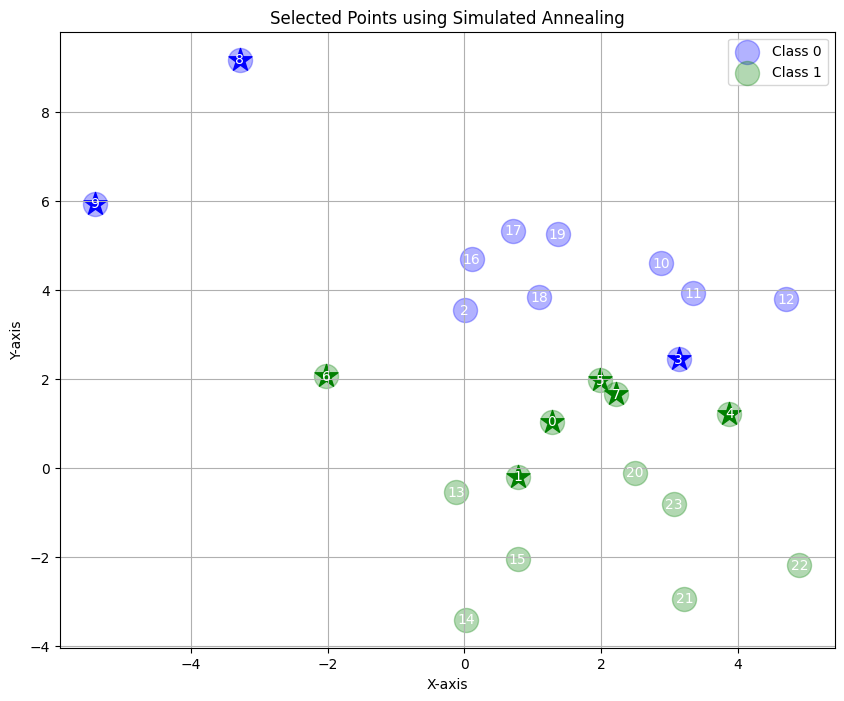

In [205]:
plot_selected_instances(X_filtered, y_filtered, selected_points) # parece que va bien, tengo que relajar penalizaciones

### Prueba con Vader NYT

In [12]:
import gzip
import numpy as np

# Load the data
with gzip.open("data/train0.gz", "rb") as fd:
    content = fd.readlines()

# Split each line by spaces
vader_nyt = [review.split(b' ') for review in content]

# Decode the bytes to strings
vader_nyt = [[entry.decode('utf-8') for entry in review] for review in vader_nyt]

# Separate labels and features
vader_nyt_labels = [row[0] for row in vader_nyt]

# Remove possible trailing newlines in the last feature
vader_nyt_features = [[float(feat.split(':')[1]) for feat in row[1:]] for row in vader_nyt]

# Convert to numpy array if you want
vader_nyt_features = np.array(vader_nyt_features)

print(len(vader_nyt_labels))       # Should be 3956
print(vader_nyt_features.shape)    # Should be (3956, 4096)
print(vader_nyt_labels[0])         # Example label
print(vader_nyt_features[0])       # Example feature vector

3956
(3956, 4096)
1
[-0.32730305 -3.1321497   1.70186234 ...  0.97825307 -0.18393582
 -1.62006617]
